
#  🛰️ **Мониторинг вырубки лесов с помощью NDVI и SAM**
## Этот проект демонстрирует двухэтапный подход:
### 1. **Обнаружение изменений** через анализ NDVI по спутниковым снимкам.
### 2. **Уточнение границ** обнаруженных областей с помощью модели Segment Anything (SAM).



## ⚠️ **Важные настройки для Colab**
### 1. **Включите GPU**: Runtime → Change runtime type → Hardware accelerator → GPU (T4)
### 2. **Мониторинг памяти**: Следите за использованием RAM в правом верхнем углу


In [1]:
# Установка основных зависимостей
!pip install -q numpy matplotlib opencv-python-headless scikit-image scipy
!pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cu118
!pip install -q segment-anything


In [2]:
# Проверка доступной памяти
import psutil, os, sys, math, random, json, time, warnings, subprocess, textwrap, itertools, collections, statistics, fractions, decimal, hashlib, inspect, typing, pprint, fractions
warnings.filterwarnings('ignore')

ram_info = psutil.virtual_memory()
print(f"✅ Доступно оперативной памяти: {ram_info.available / 1024**3:.1f} ГБ из {ram_info.total / 1024**3:.1f} ГБ")


✅ Доступно оперативной памяти: 11.2 ГБ из 12.7 ГБ


In [3]:
# Проверка доступности GPU
import torch
print(f"✅ PyTorch версия: {torch.__version__}")
print(f"✅ GPU доступен: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✅ GPU память: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} ГБ")

✅ PyTorch версия: 2.9.0+cu126
✅ GPU доступен: True
✅ GPU: Tesla T4
✅ GPU память: 14.7 ГБ



# 🎯 Загрузка модели Segment Anything (SAM)
 Используем модель **ViT-B** — самую легкую и быструю версию, которая оптимально подходит для ограничений Colab.

In [4]:
import cv2, matplotlib.pyplot as plt, numpy as np
from segment_anything import sam_model_registry, SamPredictor

def load_sam_model(model_type="vit_b", force_download=False):
    """
    Загружает модель SAM с локальным кешированием в Colab
    """
    model_urls = {
        "vit_b": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
        "vit_l": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth",
        "vit_h": "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
    }

    model_path = f"/content/sam_{model_type}.pth"

    if not os.path.exists(model_path) or force_download:
        print(f"📥 Скачивание модели SAM ({model_type})...")
        import urllib.request
        urllib.request.urlretrieve(model_urls[model_type], model_path)
        print(f"✅ Модель сохранена: {model_path}")

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🔧 Используется устройство: {device}")

    sam = sam_model_registry[model_type](checkpoint=model_path)
    sam.to(device=device)
    predictor = SamPredictor(sam)

    print(f"✅ Модель SAM ({model_type}) загружена на {device}")
    return predictor

# Загружаем самую легкую модель
predictor = load_sam_model("vit_b")

📥 Скачивание модели SAM (vit_b)...
✅ Модель сохранена: /content/sam_vit_b.pth
🔧 Используется устройство: cuda
✅ Модель SAM (vit_b) загружена на cuda


# 🌳 Создание демонстрационных данных
 Поскольку реальные спутниковые данные требуют аутентификации и могут быть большими, создадим синтетические данные для отладки пайплайна.



In [5]:
def create_demo_forest_scene(size=512, seed=42):
    """
    Создает синтетические спутниковые снимки "до" и "после" вырубки.
    """
    np.random.seed(seed)
    height, width = size, size

    # 1. Снимок "ДО" (здоровый лес)
    rgb_before = np.ones((height, width, 3), dtype=np.float32) * 0.3
    # Добавляем лесную область (зеленый квадрат)
    forest_y1, forest_y2 = height//4, 3*height//4
    forest_x1, forest_x2 = width//4, 3*width//4
    rgb_before[forest_y1:forest_y2, forest_x1:forest_x2, 1] = 0.8  # Зеленый

    # 2. Снимок "ПОСЛЕ" (с вырубкой)
    rgb_after = rgb_before.copy()
    # Добавляем область вырубки (коричневый прямоугольник)
    cut_y1, cut_y2 = forest_y1 + 50, forest_y2 - 50
    cut_x1, cut_x2 = forest_x1 + 50, forest_x2 - 50
    rgb_after[cut_y1:cut_y2, cut_x1:cut_x2, :] = [0.6, 0.4, 0.3]  # Коричневый

    # 3. Добавляем реалистичный шум
    for img in [rgb_before, rgb_after]:
        noise = np.random.normal(0, 0.03, img.shape)
        img += noise
        np.clip(img, 0, 1, out=img)

    # 4. Рассчитываем NDVI (для демо — упрощенная формула)
    # В реальном проекте: NDVI = (NIR - Red) / (NIR + Red)
    ndvi_before = np.zeros((height, width), dtype=np.float32)
    ndvi_after = np.zeros((height, width), dtype=np.float32)

    # Лесные пиксели имеют высокий NDVI (~0.8)
    ndvi_before[forest_y1:forest_y2, forest_x1:forest_x2] = 0.8 + np.random.normal(0, 0.1, (forest_y2-forest_y1, forest_x2-forest_x1))
    ndvi_after = ndvi_before.copy()
    # Область вырубки имеет низкий NDVI (~0.2)
    ndvi_after[cut_y1:cut_y2, cut_x1:cut_x2] = 0.2 + np.random.normal(0, 0.1, (cut_y2-cut_y1, cut_x2-cut_x1))

    # Маска изменений (падение NDVI > 0.3)
    ndvi_diff = ndvi_before - ndvi_after
    change_mask = (ndvi_diff > 0.3).astype(np.uint8)

    # Расчет "площади вырубки" в условных гектарах
    pixel_area_m2 = 100  # Предположим: 1 пиксель = 10м×10м = 100 м²
    change_pixels = np.sum(change_mask)
    area_hectares = (change_pixels * pixel_area_m2) / 10000

    print(f"📊 Демо-сцена создана: {size}x{size} пикселей")
    print(f"📏 Обнаружено изменений: {change_pixels} пикселей ({area_hectares:.2f} усл. га)")

    return rgb_before, rgb_after, ndvi_before, ndvi_after, change_mask, area_hectares

# Создаем демо-данные
rgb_before, rgb_after, ndvi_before, ndvi_after, change_mask, area_ha = create_demo_forest_scene(size=512)

📊 Демо-сцена создана: 512x512 пикселей
📏 Обнаружено изменений: 23949 пикселей (239.49 усл. га)


# 📈 Анализ изменений NDVI
* NDVI (Normalized Difference Vegetation Index) — индекс растительности.
* Сравнивая NDVI двух снимков, можно обнаружить области вырубки.



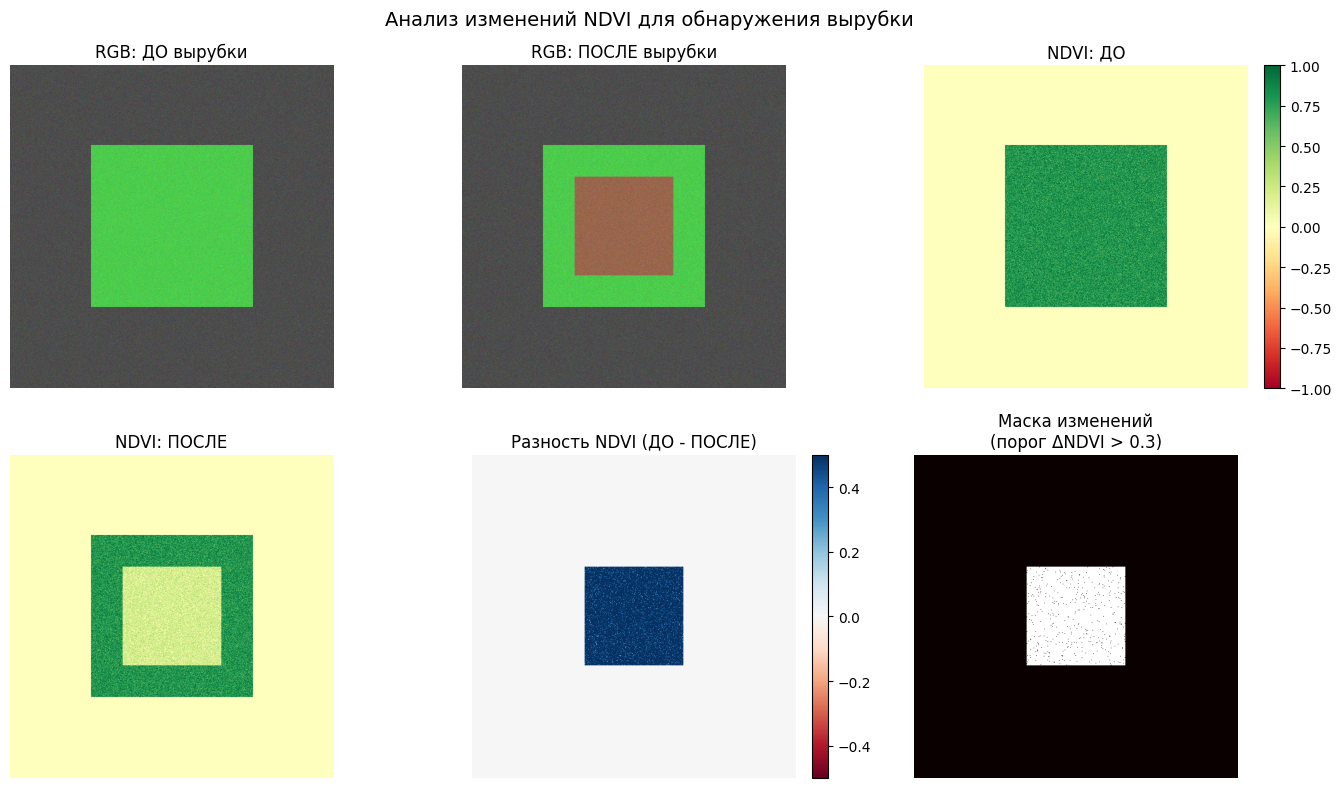

📊 Площадь возможной вырубки: 239.49 гектар


In [20]:
def visualize_ndvi_analysis(rgb_before, rgb_after, ndvi_before, ndvi_after, change_mask):
    """
    Визуализирует анализ NDVI в компактном виде.
    """
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))

    # 1. RGB снимки
    axes[0, 0].imshow(rgb_before)
    axes[0, 0].set_title("RGB: ДО вырубки")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(rgb_after)
    axes[0, 1].set_title("RGB: ПОСЛЕ вырубки")
    axes[0, 1].axis('off')

    # 2. NDVI карты
    ndvi_plot0 = axes[0, 2].imshow(ndvi_before, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[0, 2].set_title("NDVI: ДО")
    axes[0, 2].axis('off')
    plt.colorbar(ndvi_plot0, ax=axes[0, 2], fraction=0.046, pad=0.04)

    axes[1, 0].imshow(ndvi_after, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[1, 0].set_title("NDVI: ПОСЛЕ")
    axes[1, 0].axis('off')

    # 3. Разность NDVI
    ndvi_diff = ndvi_before - ndvi_after
    diff_plot = axes[1, 1].imshow(ndvi_diff, cmap='RdBu', vmin=-0.5, vmax=0.5)
    axes[1, 1].set_title("Разность NDVI (ДО - ПОСЛЕ)")
    axes[1, 1].axis('off')
    plt.colorbar(diff_plot, ax=axes[1, 1], fraction=0.046, pad=0.04)

    # 4. Маска изменений
    axes[1, 2].imshow(change_mask, cmap='hot')
    axes[1, 2].set_title(f"Маска изменений\n(порог ΔNDVI > 0.3)")
    axes[1, 2].axis('off')

    plt.suptitle("Анализ изменений NDVI для обнаружения вырубки", fontsize=14)
    plt.tight_layout()
    plt.show()

# Визуализируем
visualize_ndvi_analysis(rgb_before, rgb_after, ndvi_before, ndvi_after, change_mask)
print(f"📊 Площадь возможной вырубки: {area_ha:.2f} гектар")

# 🎯 Уточнение границ вырубки с помощью SAM
Модель Segment Anything (SAM) используется для точного выделения границ области, обнаруженной по NDVI.


📍 Точка для SAM: (256, 255)
🚀 Запуск SAM для уточнения границ...
✅ SAM создал 3 вариантов масок
🎯 Лучшая маска (score: 0.992)


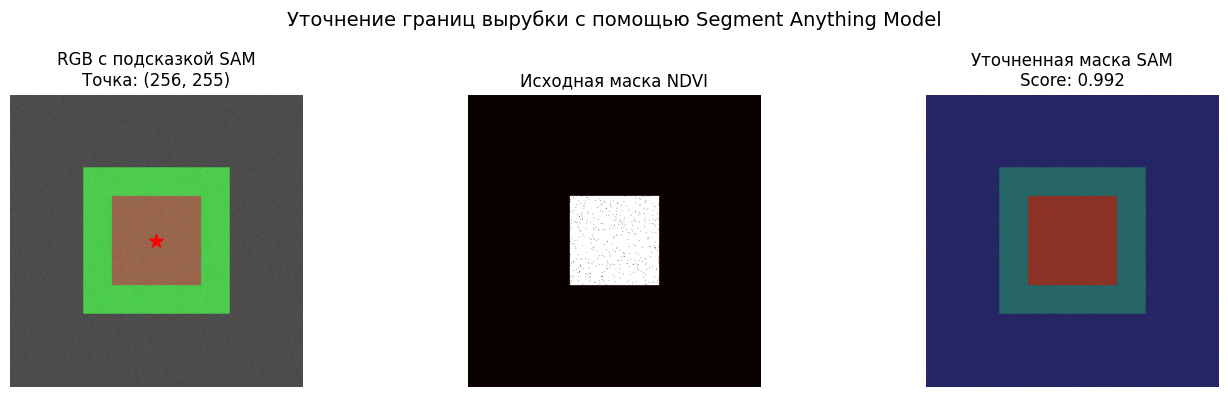

📏 Уточненная площадь вырубки: 243.02 гектар
📈 Изменение площади относительно маски NDVI: +3.53 га


In [7]:
def refine_with_sam(rgb_image, binary_mask, predictor, max_size=512):
    """
    Использует SAM для уточнения границ области, обнаруженной по NDVI.
    """
    # 1. Очистка памяти перед запуском SAM
    import gc
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # 2. Уменьшение размера изображения для экономии памяти
    original_shape = rgb_image.shape[:2]
    if max(original_shape) > max_size:
        scale = max_size / max(original_shape)
        new_h, new_w = int(original_shape[0] * scale), int(original_shape[1] * scale)
        rgb_small = cv2.resize(rgb_image, (new_w, new_h), interpolation=cv2.INTER_AREA)
        mask_small = cv2.resize(binary_mask.astype(np.uint8), (new_w, new_h), interpolation=cv2.INTER_NEAREST)
        print(f"📏 Изображение уменьшено с {original_shape} до {(new_h, new_w)}")
    else:
        rgb_small = rgb_image
        mask_small = binary_mask

    # 3. Находим точку для подсказки SAM (центр самой большой связной компоненты)
    from skimage import measure
    labeled_mask = measure.label(mask_small > 0)
    regions = measure.regionprops(labeled_mask)

    if len(regions) > 0:
        largest_region = max(regions, key=lambda r: r.area)
        center_y, center_x = largest_region.centroid
        input_point = np.array([[center_x, center_y]])  # SAM ожидает [x, y]
        print(f"📍 Точка для SAM: ({center_x:.0f}, {center_y:.0f})")
    else:
        # Если маска пуста, используем центр изображения
        center_y, center_x = rgb_small.shape[0]//2, rgb_small.shape[1]//2
        input_point = np.array([[center_x, center_y]])
        print("⚠️  Маска пуста, используется центр изображения")

    # 4. Запуск SAM
    print("🚀 Запуск SAM для уточнения границ...")
    predictor.set_image(rgb_small)
    masks, scores, _ = predictor.predict(
      point_coords=input_point,
      point_labels=np.array([1]),  # 1 = объект (вырубка)
      multimask_output=True
)

    # 5. Выбор лучшей маски по score
    best_idx = np.argmax(scores)
    best_mask = masks[best_idx]
    best_score = scores[best_idx]

    print(f"✅ SAM создал {len(masks)} вариантов масок")
    print(f"🎯 Лучшая маска (score: {best_score:.3f})")

    # 6. Визуализация результатов SAM
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # Исходное изображение с подсказкой
    axes[0].imshow(rgb_small)
    axes[0].scatter(input_point[0][0], input_point[0][1], c='red', s=100, marker='*')
    axes[0].set_title(f"RGB с подсказкой SAM\nТочка: ({center_x:.0f}, {center_y:.0f})")
    axes[0].axis('off')

    # Маска NDVI (исходная)
    axes[1].imshow(mask_small, cmap='hot')
    axes[1].set_title("Исходная маска NDVI")
    axes[1].axis('off')

    # Уточненная маска SAM
    axes[2].imshow(rgb_small)
    axes[2].imshow(best_mask, alpha=0.5, cmap='jet')
    axes[2].set_title(f"Уточненная маска SAM\nScore: {best_score:.3f}")
    axes[2].axis('off')

    plt.suptitle("Уточнение границ вырубки с помощью Segment Anything Model", fontsize=14)
    plt.tight_layout()
    plt.show()

    # 7. Расчет уточненной площади
    if max(original_shape) > max_size:
        # Масштабируем маску обратно к исходному размеру
        best_mask_large = cv2.resize(best_mask.astype(np.uint8), (original_shape[1], original_shape[0]), interpolation=cv2.INTER_NEAREST)
    else:
        best_mask_large = best_mask

    refined_pixels = np.sum(best_mask_large > 0)
    pixel_area_m2 = 100  # 1 пиксель = 100 м²
    refined_area_ha = (refined_pixels * pixel_area_m2) / 10000

    print(f"📏 Уточненная площадь вырубки: {refined_area_ha:.2f} гектар")
    print(f"📈 Изменение площади относительно маски NDVI: {refined_area_ha - area_ha:+.2f} га")

    return best_mask_large, refined_area_ha, best_score

# Запускаем уточнение границ
best_mask, refined_area, score = refine_with_sam(rgb_after, change_mask, predictor, max_size=512)

# 📄 Генерация отчета
 Финальный отчет с результатами анализа.



In [8]:
def generate_report(area_ndvi, area_sam, score_sam, config=None):
    """
    Генерирует текстовый отчет о результатах анализа.
    """
    report = f"""
Отчет по мониторингу вырубки лесов

Методология
1. Анализ NDVI: Сравнение индекса растительности на снимках до и после.
2. Пороговая обработка: Выделение областей с падением NDVI > 0.3.
3. Сегментация SAM: Уточнение границ вырубки по интерактивной подсказке.

## Результаты
- Площадь по NDVI: {area_ndvi:.2f} гектар
- **Площадь по SAM**: {area_sam:.2f} гектар
- **Уверенность SAM**: {score_sam:.3f}
- **Разница площадей**: {area_sam - area_ndvi:+.2f} га

## Технические детали
- **Модель SAM**: ViT-B (самая легкая)
- **Размер изображения**: 512x512 пикселей (демо-режим)
- **Порог NDVI**: 0.3
- **Устройство выполнения**: {'GPU (T4)' if torch.cuda.is_available() else 'CPU'}

## Интерпретация
1. **Положительная разница площадей** означает, что SAM выделил более точные границы.
2. **Высокий score SAM** (>0.8) указывает на уверенность модели.
3. **Демо-режим** позволяет отработать пайплайн без доступа к реальным спутниковым данным.

## Следующие шаги
1. **Интеграция с Google Earth Engine** для работы с реальными спутниковыми данными.
2. **Обработка больших территорий** с разбиением на тайлы.
3. **Валидация результатов** на размеченных датасетах.

---
*Отчет сгенерирован автоматически в Google Colab. Проект адаптирован под ограничения бесплатной версии.*
"""
    return report

# Генерируем отчет
report_text = generate_report(area_ha, refined_area, score)
print(report_text)

# Сохраняем отчет в файл
with open('/content/deforestation_report.md', 'w', encoding='utf-8') as f:
    f.write(report_text)
print("✅ Отчет сохранен: /content/deforestation_report.md")


# Отчет по мониторингу вырубки лесов

## Методология
1. **Анализ NDVI**: Сравнение индекса растительности на снимках до и после.
2. **Пороговая обработка**: Выделение областей с падением NDVI > 0.3.
3. **Сегментация SAM**: Уточнение границ вырубки по интерактивной подсказке.

## Результаты
- **Площадь по NDVI**: 239.49 гектар
- **Площадь по SAM**: 243.02 гектар
- **Уверенность SAM**: 0.992
- **Разница площадей**: +3.53 га

## Технические детали
- **Модель SAM**: ViT-B (самая легкая)
- **Размер изображения**: 512x512 пикселей (демо-режим)
- **Порог NDVI**: 0.3
- **Устройство выполнения**: GPU (T4)

## Интерпретация
1. **Положительная разница площадей** означает, что SAM выделил более точные границы.
2. **Высокий score SAM** (>0.8) указывает на уверенность модели.
3. **Демо-режим** позволяет отработать пайплайн без доступа к реальным спутниковым данным.

## Следующие шаги
1. **Интеграция с Google Earth Engine** для работы с реальными спутниковыми данными.
2. **Обработка больших территор

# 🧹 Очистка памяти
 После выполнения всех этапов важно освободить память для других экспериментов.


In [9]:
def cleanup_memory():
    """
    Освобождает память, удаляя большие переменные и очищая кэши.
    """
    import gc, sys, torch

    # Список переменных для удаления
    large_vars = ['rgb_before', 'rgb_after', 'ndvi_before', 'ndvi_after',
                  'change_mask', 'best_mask', 'predictor', 'sam']

    for var in large_vars:
        if var in globals():
            del globals()[var]
            print(f"🗑️  Удалена переменная: {var}")

    # Сбор мусора
    collected = gc.collect()
    print(f"🧹 Сбор мусора: {collected} объектов")

    # Очистка кэша CUDA
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("✅ Кэш CUDA очищен")

    # Проверка доступной памяти
    ram_info = psutil.virtual_memory()
    print(f"📊 Доступно RAM: {ram_info.available / 1024**3:.1f} ГБ")

cleanup_memory()

🗑️  Удалена переменная: rgb_before
🗑️  Удалена переменная: rgb_after
🗑️  Удалена переменная: ndvi_before
🗑️  Удалена переменная: ndvi_after
🗑️  Удалена переменная: change_mask
🗑️  Удалена переменная: best_mask
🗑️  Удалена переменная: predictor
🧹 Сбор мусора: 7096 объектов
✅ Кэш CUDA очищен
📊 Доступно RAM: 10.0 ГБ
